# Cantera module for Flamelet Generated Manifolds
We are going to run a series of free flames, visualise them and create an FGM for ANSYS Fluent. 
As always, go through this interactive notebook in jupyter (jupyter labs or jupyter notebook), read carefully what we do, try to understand the piece of code and follow the instructions. 
You can execute the selected cell one by one using the play button at the top or pressing SHIFT+ENTER.
First we load the necessary libraries.
For help on the cantera commands see https://cantera.org/documentation/

In [1]:
# use this for standard jupyter notebook visualization
%matplotlib inline

# with a local install you can use qt5 and get pop-up windows with interactive graphics (pan, zoom, edit)
#%matplotlib qt5

matplotlib inline will embed the matplotlib figures in your notebook document. 
If qt5 is installed (not on the online binder unfortunately), figures will be created in an interactive external window.

In [2]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import csv

We have seen previously that cantera uses local grid adaptation and the final flame solution does not have a fixed number of grid points in the x-direction. If we are going to convert the data f(x) to f(c), where c is the progress variable, then we also have a variable number of points in the progress variable direction. We want to have solutions with a fixed number of points so it can be easily stored in an array, eg. an array with 200 points in progress variable direction and 100 points in the enthalpy direction.
We will need some interpolation routines to create results with the same number of points in the progress variable direction.

In [3]:
# linearly interpolate and get T at point p using input data (x,T)
def interpoint(p,x,T):
    if (p<x[0] or p>x[len(x)-1]):
        raise ValueError("point p=",p," is not inside the domain with boundaries [",x[0],",",x[len(x)-1],")")
    # immediately return correct value when p is on the boundary
    if (abs(p-x[0])<1.0e-16):
        return(T[0])
    if (abs(p-x[len(x)-1])<1.0e-16):
        return(T[len(x)-1])
    i=0
    Tvalue=0
    pointfound=False
    while((i<(len(x)-1)) and not(pointfound)):       
        if (x[i]<=p and x[i+1]>p) :
            dx = x[i+1]-x[i]
            if (dx==0):
                raise ValueError("two spatial points have the same value! ",x[i+1],x[i])
            dT = T[i+1]-T[i]
            Tvalue=T[i] + (p-x[i]) * (dT/dx)
            pointfound=True
        i=i+1
    return(Tvalue)

# interpolate T at the list of locations xnew using x,T
def interplist(xnew,xold,Told):
    Tnew=[]
    for x in xnew:
        Tnew.append(interpoint(x,xold,Told))
    return(Tnew)

# compute change dT on the input data T
def dT(x,T):
    gradlist=[]
    for i in range(len(T)-1):
        #gradlist.append((T[i+1]-T[i])/(x[i+1]-x[i]))
        # we compute dT*dT so we have always have a positive change
        gradlist.append((T[i+1]-T[i])**2)
    return gradlist

# add a new point at an optimal location according to temperature changes
# we look at the change in T (not dT/dx!) so large elements with small gradients will also be refined
def addoptimal(xcopy,Ycopy,Tcopy,xold,Yold,Told):
    # remember: input arguments are modified if they are lists!
    x = xcopy.copy()
    Y = Ycopy.copy()
    T = Tcopy.copy()
    
    # compute temperature change in y-direction (not dT/dx)
    gT = dT(x,T)
    
    #print("gradients = ",gT)
    # get the maximum change
    gTmax = max(gT)
    # get the index of the cell with the maximum change
    gTmaxindex = np.where(gT == gTmax)[0][0]
    
    #x = np.insert(x,gTmaxindex+1,0.5*(x[gTmaxindex+1]+x[gTmaxindex]))
    #T = np.insert(T,gTmaxindex+1,0.5*(T[gTmaxindex+1]+T[gTmaxindex]))
    
    # use original data for interpolation
    px = 0.5*(x[gTmaxindex+1]+x[gTmaxindex])
    # insert a point in the grid x in the cell with maximum Temperature change
    x = np.insert(x,gTmaxindex+1,px)
    # interpolate value of Y
    T = np.insert(T, gTmaxindex+1, interpoint(px,xold,Told))
    Y = np.insert(Y, gTmaxindex+1, interpoint(px,xold,Yold))

    return x,Y,T

# Our starting point is an array x and Y, with temperature T
# we then create a new initial equidistant mesh xnew and we first interpolate onto the new mesh
# then we want to add points until we have reached the new N
# we use gradients of temperature T a
def newmesh(xold,Yold,Told,N):
    initialN = 10
    if N<(initialN+1):
        raise ValueError("number of points must be larger than ",initialN)
    # initial equidistant mesh distribution
    xnew=np.linspace(xold[0],xold[len(xold)-1],10) 

    Tnew=interplist(xnew,xold,Told)
    # interpolate Ynew on the new mesh xnew
    Ynew=interplist(xnew,xold,Yold)
    
    # now we add points until we reach N points
    for n in range(initialN+1,N+1,1):
        xnew, Ynew,Tnew = addoptimal(xnew,Ynew,Tnew,xold,Yold,Told)
    return xnew,Ynew

With the routines above, specifically with the function *newmesh(xold,myold,Told,N)* we can remesh a solution onto a new mesh with a certain number of gridpoints N. The new mesh will still have a nonuniform distribution of grid points, so more points are added in the region where the temperature changes are larger. This is less advanced than what cantera is doing, but good enough to create our FGM. 


Recall that with FGM, we want to avoid solving all species transport equations and instead solve only one equation that represents all the species: the progress variable. For a given equivalence ratio and (total) enthalpy, the mass fraction of all other species is a unique function of the progress variable. Also the temperature, viscosity, density, etc. are unique function of the progress variable. We compute a 1D free flame and save the information as a function of the progress variable. The definition of the progress variable is not very important, as long as all our quantities can be uniquely identified with the progress variable. During our 2D or 3D computations in Fluent, we solve only the transport equation of the progress variable (together with the flow and energy equations) and retrieve the other species information from our stored 1D results (our lookup table). If the enthalpy changes because of heat losses in the domain (due to e.g. cold walls)  we have to save the result of multiple flame solutions with enthalpies that cover the enthalpy range in our 2D or 3D computation.

Recall our setup of a 1D free flame. Below is the cantera code for a methane-air flame with equivalence ratio $\phi=0.80$ and unity Lewis number. 

In [4]:
# Simulation parameters
p = ct.one_atm  # pressure [Pa]
T_unburnt = 300.0  # unburned gas temperature [K]
width = 0.03  # m
loglevel = 0  # amount of diagnostic output (0 to 8)

gas = ct.Solution('gri30.xml')

phi = 0.80
fuel_species = 'CH4'
air_composition='O2:0.21,N2:0.79'
gas.TP = T_unburnt,p
gas.set_equivalence_ratio(phi,fuel_species,air_composition)

# Set up flame object
f = ct.FreeFlame(gas, width=width)
# use some mesh refinement
# smaller values are better but take more time and lead to more grid points.
f.set_refine_criteria(ratio=3, slope=0.06, curve=0.12)

# Solve with Unity Lewis transport model
f.transport_model = 'UnityLewis'
f.solve(loglevel=loglevel, auto=True)

print('Done! unity Lewis flamespeed = {0:7f} m/s'.format(f.u[0]))

Done! unity Lewis flamespeed = 0.247192 m/s


We have used Cantera's automatic regridding to get a more optimal solution. More points are added at locations with large gradients in the solution. However, we need a fixed number of points N in progress variable space and a fixed number of points in enthalpy space for our lookup table (else we would not have a nice table with X\*Y points). The number of points do not have to be equally distributed in the lookup table as long as we have the same number of points in the x-direction and y-direction. Let's first look at the solution and the distribution of the points

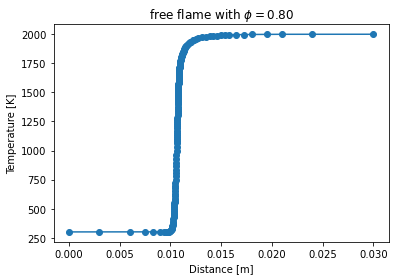

In [5]:
plt.figure()

#We can globally change the figure size 
plt.rcParams['figure.figsize'] = [8, 4]
#plt.xlim(0.0,0.024)
plt.plot(f.grid,f.T,'o-')
plt.title('free flame with $\phi=0.80$')
plt.xlabel('Distance [m]')
plt.ylabel('Temperature [K]');


The temperature looks good and we see that more points have been added in the region with the large temperature gradient. Let's also look at the production of CO2.

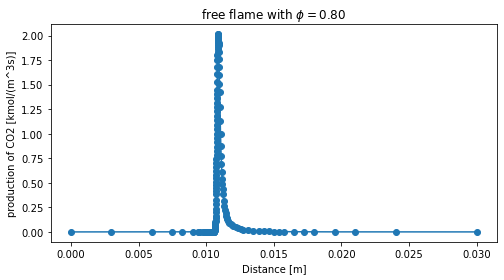

In [6]:
plt.figure()

#We can globally change the figure size 
plt.rcParams['figure.figsize'] = [8, 4]
#plt.xlim(0.00,0.024)
plt.plot(f.grid,f.net_production_rates[gas.species_index('CO2')],'o-')
plt.title('free flame with $\phi=0.80$')
plt.xlabel('Distance [m]')
plt.ylabel('production of CO2 [kmol/(m^3s)]');

A very steep peak! We see that this peak is captured correctly by the refinement procedure. For the FGM, we need to construct a table with different enthalpies. We can change the enthalpy by changing the initial, unburnt temperature of a free flame, or by lowering the mass burning rate of a burner stabilized flame (so it loses more heat to the burner). Let's first look at changing the initial temperature

In [7]:
# We are going to create an FGM with different enthalpy levels.
# To increase the enthalpy, we can increase the inlet temperature of the mixture. 
# We are going to create a list of flames with unburnt temperatures of T=300,400,500,600
# This will take a couple of minutes to run...

# we compute in order of lower enthalpy, so it also ends up in the list like that.
T_unburnt_list = [300,400,500,600]

# we store the individual flame solutions in a list of flame solutions
flamelist = []

for T_unburnt in T_unburnt_list:
    print("initial, unburnt temperature = ",T_unburnt)
    # Simulation parameters
    p = ct.one_atm  # pressure [Pa]
    width = 0.03  # m
    loglevel = 0  # amount of diagnostic output (0 to 8)

    gas = ct.Solution('gri30.xml')

    # equivalence ratio 
    phi = 0.80
    fuel_species = 'CH4'
    air_composition='O2:0.21,N2:0.79'
    gas.TP = T_unburnt,p
    gas.set_equivalence_ratio(phi,fuel_species,air_composition)

    # Set up flame object
    flame = ct.FreeFlame(gas, width=width)
    flame.set_refine_criteria(ratio=3, slope=0.06, curve=0.12)
    #f.show_solution()

    # Solve with Unity Lewis transport model
    flame.transport_model = 'UnityLewis'
    #flame.solve(loglevel=loglevel, auto=True)
    flame.solve(loglevel) # don't use 'auto' on subsequent solves
    flamelist.append(flame)
    
print("We are done here!")

initial, unburnt temperature =  300
initial, unburnt temperature =  400
initial, unburnt temperature =  500
initial, unburnt temperature =  600
We are done here!


Let's check some results. First the temperature...

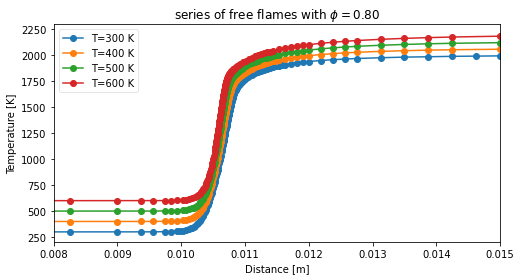

In [8]:
# let's plot some results. First we create an empty figure
plt.figure()
#We can globally change the figure size 
plt.rcParams['figure.figsize'] = [12, 6]
plt.xlim(0.008,0.015)
plt.plot(flamelist[0].grid,flamelist[0].T,'o-',label='T=300 K')
plt.plot(flamelist[1].grid,flamelist[1].T,'o-',label='T=400 K')
plt.plot(flamelist[2].grid,flamelist[2].T,'o-',label='T=500 K')
plt.plot(flamelist[3].grid,flamelist[3].T,'o-',label='T=600 K')
plt.title('series of free flames with $\phi=0.80$')
plt.xlabel('Distance [m]')
plt.ylabel('Temperature [K]')
# place a semi-transparent legend on the figure at a specified location
plt.legend(framealpha=0.5,frameon=True,loc='upper left')
# show, the figure will be shown anyway but now the last command in the cell is show instead
# of another command, and the last command in the cell will be printed as well.
plt.show()

We have a nice set of solutions for different temperatures. Now we interpolate these solutions onto a new grid with an equal number of points. Note that the grid is not *equidistant*, so the distance $\Delta x$ between the points is not a constant. Let's first interpolate the temperature.

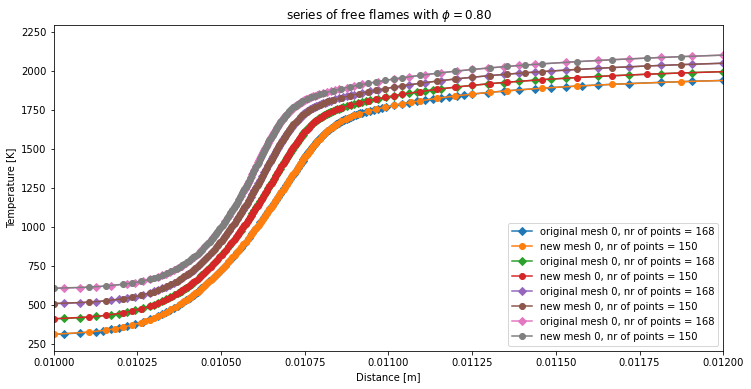

In [9]:
# intepolate onto new mesh
X0 = flamelist[0].grid
T0 = flamelist[0].T
X0new,T0new = newmesh(X0,T0,T0,150)
#H0=np.full((X0new.size,),flamelist[0].enthalpy_mass[0])

X1 = flamelist[1].grid
T1 = flamelist[1].T
X1new,T1new = newmesh(X1,T1,T1,150)
#H1=np.full((X1new.size,),flamelist[1].enthalpy_mass[1])

X2 = flamelist[2].grid
T2 = flamelist[2].T
X2new,T2new = newmesh(X2,T2,T2,150)
#H2=np.full((X2new.size,),flamelist[2].enthalpy_mass[2])

X3 = flamelist[3].grid
T3 = flamelist[3].T
X3new,T3new = newmesh(X3,T3,T3,150)
#H3=np.full((X3new.size,),flamelist[3].enthalpy_mass[3])

string1='original mesh 0, nr of points = '+str(len(X0))
string2='new mesh 0, nr of points = '+str(len(X0new))
string3='original mesh 1, nr of points = '+str(len(X1))
string4='new mesh 1, nr of points = '+str(len(X1new))
string5='original mesh 2, nr of points = '+str(len(X2))
string6='new mesh 2, nr of points = '+str(len(X2new))
string7='original mesh 3, nr of points = '+str(len(X3))
string8='new mesh 3, nr of points = '+str(len(X3new))

plt.xlim(0.010,0.012)
plt.title('series of free flames with $\phi=0.80$')
plt.xlabel('Distance [m]')
plt.ylabel('Temperature [K]')
# let's visualize temperature
plt.plot(X0,T0,'D-',label=string1)
plt.plot(X0new,T0new,'o-',label=string2)

plt.plot(X1,T1,'D-',label=string1)
plt.plot(X1new,T1new,'o-',label=string2)

plt.plot(X2,T2,'D-',label=string1)
plt.plot(X2new,T2new,'o-',label=string2)

plt.plot(X3,T3,'D-',label=string1)
plt.plot(X3new,T3new,'o-',label=string2)

plt.legend()
plt.show()

We see that the temperature on the new mesh is still accurate. We have used a very simple local refinement procedure based on temperature gradients. Any properties that have large gradients outside of the region with strong temperature gradients will not be represented accurately, e.g. species that are produces or consumed early or late in the flame front. Let's check the net production of some species. Our original meshes in this case all have 168 points. They have the same number of points for this case because the solutions are still very much the same, but this is not guaranteed! Let's look at the production of $CO_2$.

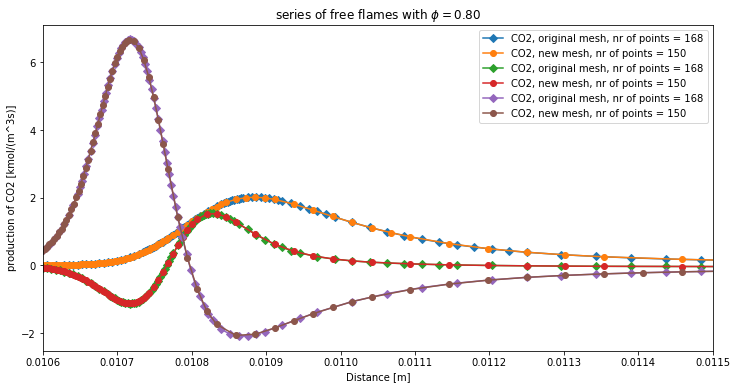

In [10]:
# intepolate onto new mesh
X0 = flamelist[0].grid
Y0 = flamelist[0].net_production_rates[gas.species_index('CO2')]
T0 = flamelist[0].T
X0new,Y0new = newmesh(X0,Y0,T0,150)
#H0=np.full((X0new.size,),flamelist[0].enthalpy_mass[0])

X1 = flamelist[1].grid
Y1 = flamelist[1].net_production_rates[gas.species_index('OH')]
T1 = flamelist[1].T
X1new,Y1new = newmesh(X1,Y1,T1,150)
#H1=np.full((X1new.size,),flamelist[1].enthalpy_mass[1])

X2 = flamelist[2].grid
Y2 = flamelist[2].net_production_rates[gas.species_index('CO')]
T2 = flamelist[2].T
X2new,Y2new = newmesh(X2,Y2,T2,150)
#H2=np.full((X2new.size,),flamelist[2].enthalpy_mass[2])



string1='CO2, original mesh, nr of points = '+str(len(X0))
string2='CO2, new mesh, nr of points = '+str(len(X0new))

plt.xlim(0.0106,0.0115)
plt.title('series of free flames with $\phi=0.80$')
plt.xlabel('Distance [m]')
plt.ylabel('production of CO2 [kmol/(m^3s)]');

plt.plot(X0,Y0,'D-',label=string1)
plt.plot(X0new,Y0new,'o-',label=string2)

plt.plot(X1,Y1,'D-',label=string1)
plt.plot(X1new,Y1new,'o-',label=string2)

plt.plot(X2,Y2,'D-',label=string1)
plt.plot(X2new,Y2new,'o-',label=string2)
plt.legend()
plt.show()

we see that also for the production rate of $CO_2$, we capture the shape accurately. Note that the production rate is in kmol/m^3s and Fluent uses kg/m^3s, so we have to multiply by the molecular weight of the species to get the same units. The production of $CO_2$ can then be added as a source term to the transport equation of $CO_2$ (the progress variable). 

We are going to create an FGM for use in Fluent. Fluent has a user defined function (UDF) that can read the FGM file. The FGM file starts with a header, containing information about the FGM. After constructing the header, we write the FGM data as column data in plain text format (ASCII format).

In [11]:
# write-fgm

# points in progress variable direction
# note that it does not make sense to use more points than the original flame solution has. We do not add any accuracy, only computation time, memory and disc space!

pvpoints = 150

# points in enthalpy direction. This is the number of flames that we have computed. We are not going to interpolate in the direction of enthalpy
enthpoints = len(flamelist)

strdatasize=str(pvpoints) + " " + str(enthpoints) + "\n"
strgridpower="1.0 1.0\n"
strpoints=str(pvpoints) + " " + str(enthpoints)
print(strpoints)

fgmheader=["[FGM]\n",
           "2DRLR\n",
           "[DIMENSION]\n",
           "2\n",
           "[CVDEFINITION]\n",
           "2\n",
           "CO2  1.0 0.0\n",
           "ENTHALPY 0.0 1.0\n",
           "[END]\n",
           "[DATASIZE]\n", 
           strdatasize, 
           "[GRIDPOWER]\n", 
           strgridpower,
           "[VARIABLES]\n",]

# these are the variables that we want to save to the FGM
varlist=["CV1\n",
         "CV2\n",
         "SOURCE_CV1\n",
         "SOURCE_CV2\n",
         "DIFF_CV1\n",
         "DIFF_CV2\n",
         "DENSITY\n",
         "TEMPERATURE\n",
         "CP\n",
         "CONDUCTIVITY\n", 
         "VISCOSITY\n", 
         "HEATRELEASE\n",
         "CH4\n",
         "CO\n",
         "CO2\n",
         "O2\n",
         "ENTHALPY\n",
        ]

print(varlist)

# in case we just want all the species, that's a bit too much
#for i, specie in enumerate(gas.species()):
#    varlist.append(str(specie).replace('<Species ','').replace('>','')+" \n")

#varlist.append("ENTHALPY \n")
#print(varlist)

# number of variables
numvar = len(varlist)
print(numvar)

# add the variables list to the header
fgmheader.append(str(numvar)+"\n")
fgmheader = fgmheader + varlist
fgmheader.append("[END]\n")
fgmheader.append("[DATA]\n")

print(fgmheader)


# open the file for writing, create if file does not exist, overwrite if file exists
fgmfile = open("database.fgm","w",newline='')

# write the header
fgmfile.writelines(fgmheader)

# construct all the variable that we want to save to the FGM
# we want to have the same number of point in progress variable direction, 
# so we use our interpolation method
# newmesh(X,Y,T,150)

counter1=0
for f in flamelist:
    counter1=counter1+1
    print("flame number ",counter1)
    
    # old mesh and temperature
    X = f.grid
    T = f.T

    # index to the species that acts as a progress variable (CO2)
    iPV=flamelist[0].gas.species_index('CO2')
    MolWeight_CO2 = flamelist[0].gas.molecular_weights[iPV]


    # first control variable: progress variable
    grid,CV1=newmesh(X,f.Y[iPV],T,pvpoints)

    # second control variable: enthalpy
    # for enthalpy we assume a constant value. We take the first value from the list
    #grid,ENTHALPY = newmesh(X,f.enthalpy_mass,T,pvpoints)
    ENTHALPY = np.ones(len(grid))*f.enthalpy_mass[0]
    CV2=ENTHALPY

    grid,SOURCE_CV1 = newmesh(X,f.net_production_rates[iPV],T,pvpoints)
    SOURCE_CV1 = SOURCE_CV1 * MolWeight_CO2
    SOURCE_CV2 = 0
    grid,CONDUCTIVITY = newmesh(X,f.thermal_conductivity,T,pvpoints)

    grid,CP = newmesh(X,f.cp_mass,T,pvpoints)

    grid,DENSITY = newmesh(X,f.density,T,pvpoints)

    
    DIFF_CV1 = 0
    DIFF_CV2 = 0

    grid,VISCOSITY=newmesh(X,f.viscosity,T,pvpoints)
    grid,TEMPERATURE=newmesh(X,f.T,T,pvpoints)
    grid,HEATRELEASE=newmesh(X,f.heat_release_rate,T,pvpoints)

    # which species do we want to write to the FGM?
    grid,SPECIES1 = newmesh(X,f.X[gas.species_index("CH4")],T,pvpoints)
    grid,SPECIES2 = newmesh(X,f.X[gas.species_index("CO")],T,pvpoints)
    grid,SPECIES3 = newmesh(X,f.X[gas.species_index("CO2")],T,pvpoints)
    grid,SPECIES4 = newmesh(X,f.X[gas.species_index("O2")],T,pvpoints)

 
    # write the data, loop over the enthalpy points
    # for i in range
    # write the data, loop over the progress variable points
    for i in range(0,pvpoints):
        fgmline = [CV1[i],CV2[i],
                   SOURCE_CV1[i],SOURCE_CV2,
                   DIFF_CV1,DIFF_CV2,
                   DENSITY[i],
                   TEMPERATURE[i],
                   CP[i],
                   CONDUCTIVITY[i],
                   VISCOSITY[i],
                   HEATRELEASE[i],
                   SPECIES1[i],
                   SPECIES2[i],
                   SPECIES3[i],
                   SPECIES4[i],
                   ENTHALPY[i]]
    
        wr=csv.writer(fgmfile,delimiter=' ',lineterminator='\n')
        wr.writerow("%e" % item for item in fgmline)
       
# end of all data, close everything    
fgmfile.write("[END]")
fgmfile.close()

150 4
['CV1\n', 'CV2\n', 'SOURCE_CV1\n', 'SOURCE_CV2\n', 'DIFF_CV1\n', 'DIFF_CV2\n', 'DENSITY\n', 'TEMPERATURE\n', 'CP\n', 'CONDUCTIVITY\n', 'VISCOSITY\n', 'HEATRELEASE\n', 'CH4\n', 'CO\n', 'CO2\n', 'O2\n', 'ENTHALPY\n']
17
['[FGM]\n', '2DRLR\n', '[DIMENSION]\n', '2\n', '[CVDEFINITION]\n', '2\n', 'CO2  1.0 0.0\n', 'ENTHALPY 0.0 1.0\n', '[END]\n', '[DATASIZE]\n', '150 4\n', '[GRIDPOWER]\n', '1.0 1.0\n', '[VARIABLES]\n', '17\n', 'CV1\n', 'CV2\n', 'SOURCE_CV1\n', 'SOURCE_CV2\n', 'DIFF_CV1\n', 'DIFF_CV2\n', 'DENSITY\n', 'TEMPERATURE\n', 'CP\n', 'CONDUCTIVITY\n', 'VISCOSITY\n', 'HEATRELEASE\n', 'CH4\n', 'CO\n', 'CO2\n', 'O2\n', 'ENTHALPY\n', '[END]\n', '[DATA]\n']
flame number  1
flame number  2
flame number  3
flame number  4


An FGM was saved to a file and this file can now be used in Fluent. In the example above, only a very small enthalpy range was used, so we can have only very little heat loss in our Fluent computations. Actually, when the inlet temperature in the Fluent simulation is 300K, then we can only perform simulations where heat is *added*, e.g. because there is a hot surface in the domain. For heat losses, we should have added a flame with an inlet temperature of e.g. $T_u=250K$. However, for very low temperatures many gas properties are not accurately known. For instance, the heat capacity relationships are usually valid only for temperatures $T>250 K$.  We can increase the allowed heat losses in our simulation by adding burner stabilized flames to the table. There is also a limitation here because even when the mass burning rate is very low, the enthalpy loss in the burner stabilized flame will still be limited. We can compute the enthalpy of a completely burnt and cooled gas using the knowledge from the first module (compute the equilibrium solution). Also remember that when the gas is completely burnt and cooled, no reactions are taken place anymore.

In [12]:
gas = ct.Solution('gri30.xml')
gas.transport_model = 'UnityLewis'
gas.TPX = 300.0, ct.one_atm, 'CH4:0.8,O2:2,N2:7.52'
gas.equilibrate('TP')

We see from the composition that the mixture is completely burned and the temperature is 300K. We also see that the total enthalpy of this mixture is $h=-2.4\cdot10^6 \frac{J}{kg}$. We can create a final flame with this equilibrium information and add it to our table. For this, we can simply copy the final composition $N_p$ times, which is the number of points in the progress variable direction.

In [13]:

iPV=gas.species_index('CO2')
flame_final_CV1 = np.ones(150)*gas.Y[iPV]
flame_final_CV2 = np.ones(150)*gas.enthalpy_mass
flame_final_SOURCE_CV1=np.ones(150)*0.0
flame_final_SOURCE_CV2=np.ones(150)*0.0
flame_final_DIFF_CV1=np.ones(150)*gas.thermal_conductivity/gas.cp_mass
flame_final_DIFF_CV2=np.ones(150)*gas.thermal_conductivity/gas.cp_mass
flame_final_DENSITY=np.ones(150)*gas.density
flame_final_TEMPERATURE=np.ones(150)*gas.T
flame_final_CP=np.ones(150)*gas.cp_mass
flame_final_CONDUCTIVITY=np.ones(150)*gas.thermal_conductivity
flame_final_VISCOSITY=np.ones(150)*gas.viscosity
flame_final_HEATRELEASE=np.ones(150)*0.0
flame_final_SPECIES1=np.ones(150)*gas.Y[gas.species_index('CH4')]
flame_final_SPECIES2=np.ones(150)*gas.Y[gas.species_index('CO')]
flame_final_SPECIES3=np.ones(150)*gas.Y[gas.species_index('CO2')]
flame_final_SPECIES4=np.ones(150)*gas.Y[gas.species_index('O2')]
flame_final_ENTHALPY=flame_final_CV2

In [14]:
# visualize the FGM. For this, we construct an array of all points (x,y), or in our case (c,h)

import matplotlib.tri as tri
plt.rcParams['figure.figsize'] = [16,12]

pvpoints = 150

# initialize the empty arrays
H = np.array([],dtype=float)
c = np.array([],dtype=float)
TEMPERATURE = np.array([],dtype=float)

# loop over flames and compute all the coordinates H,c and the values T
for i in range(len(flamelist)):
    # we reverse the order, so the highest enthalpy (the 'top' row) is first.
    j = len(flamelist)-i-1
    
    X = flamelist[j].grid
    T = flamelist[j].T
    
    #newmesh(X,f.X[gas.species_index("CH4")],T,pvpoints)
    h = np.full(pvpoints,flamelist[j].enthalpy_mass[0])
    H = np.concatenate((H,h))
    
    grid,CO2 = newmesh(X, flamelist[j].X[gas.species_index("CO2")], T, pvpoints)
    c = np.concatenate((c,CO2))

    grid,T1 = newmesh(X,flamelist[j].T,T,pvpoints)
    TEMPERATURE = np.concatenate((TEMPERATURE,T1))
    
    
# add the equilibrium value at the bottom
H = np.concatenate((H,flame_final_CV2))
c = np.concatenate((c,flame_final_CV1))
TEMPERATURE = np.concatenate((TEMPERATURE,flame_final_TEMPERATURE))

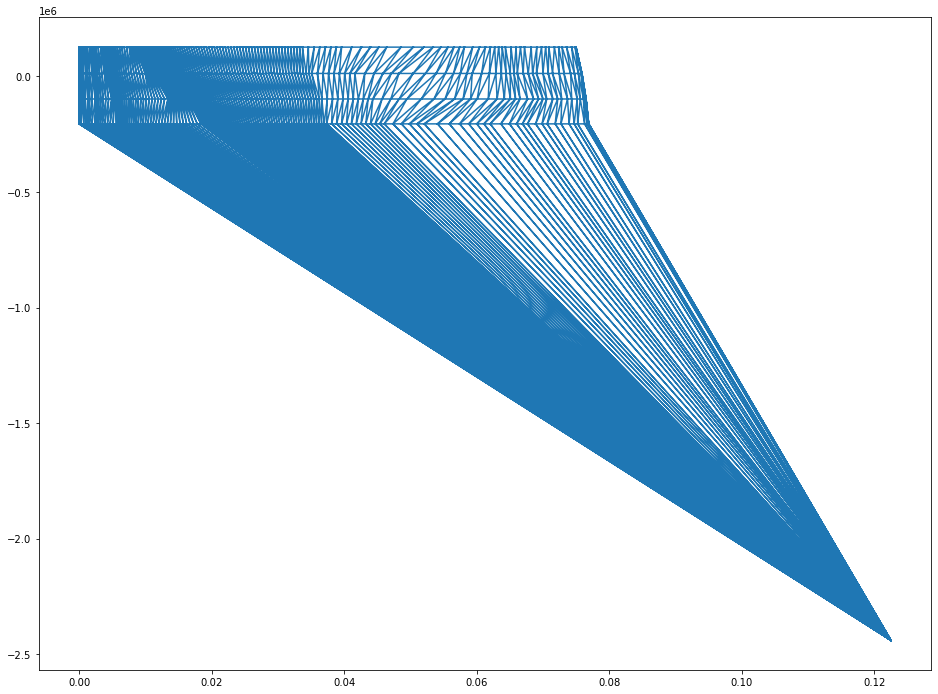

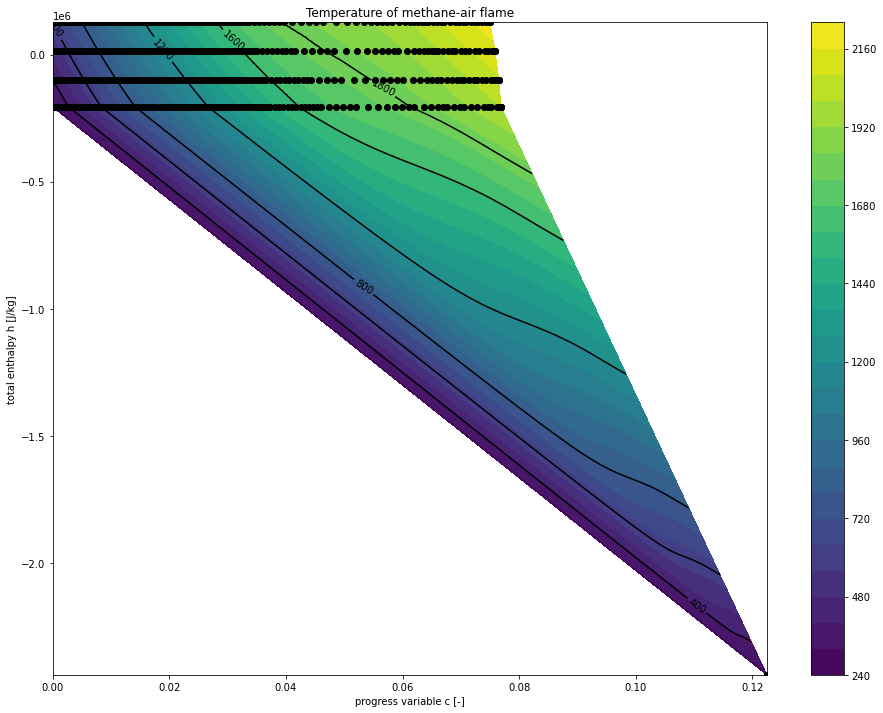

In [15]:
# construct a proper triangulation
npv=pvpoints
# number of flames + equilibrium point
nh=5

tria01 = np.ones(((npv-1)*(nh-1)*2,3),dtype=np.int32)
index=0

for j in range(nh-1):
    for i in range(npv-1):        
        tria01[index*2]   =[npv*j + i+1, npv*j + i,     (j+1)*npv+i]
        tria01[index*2+1] =[(j+1)*npv+i, (j+1)*npv+i+1, npv*j + i+1]
        index=index+1
        #print(index," ",i," ",j," (",npv*j + i+1, npv*j + i,(j+1)*npv+i,"),(",(j+1)*npv+i,(j+1)*npv+i+1,npv*j + i+1, ")")
    
# plot the mesh
plt.triplot(c, H,tria01)


# create a contour plot
fig, ax = plt.subplots()
ax.set_title('Temperature of methane-air flame')
ax.set_xlabel('progress variable c [-]')
ax.set_ylabel('total enthalpy h [J/kg]')
tcf = ax.tricontourf(c,H,tria01,TEMPERATURE, 30) # contour plot, using xx number of colored contour levels

# Define black line contour levels in temperature where we want lines to appear
levels = np.array([400, 600, 800, 1200, 1600, 1800])
# Set all contour level lines to black
line_colors = ['black' for l in tcf.levels]
cp = ax.tricontour(c, H, tria01,TEMPERATURE, levels=levels, colors=line_colors)
# format of label text on the contour lines, it is a float (real) with 0 digits. Positioning is automatic
ax.clabel(cp, fontsize=10, fmt='%.0f',colors=line_colors)

# colorbar
fig.colorbar(tcf)

# visualize data points
ax.plot(c,H, 'ko')

plt.show()

When visualizing the data points, we see that the free flames and burner stabilized flames fill the upper part of the FGM (the black dots). A large part of the lower enthalpy region is not covered by simulation data. Only the final, lowest enthalpy is computed by equilibrium chemistry. Everything between the last solution of the burner stabilized flame and the equilibrium chemistry solution is interpolated. Most reactions have stopped at these low enthalpies.

# Assignment 4.1
Create an FGM
- for unity Lewis number and $\phi=0.70$ you are going to create an FGM and save it to a file.
- First, solve a series of free flames with temperatures $Tu=[275,300,325,350,375,400,425,450,475,500,525,550,575,600]$
- Then, solve a series of burner stabilized flames. use $T_u=275 K$ and starting from a mass flow rate $\dot m$ that is 90% of the maximum mass flow rate $\dot m_{max}$ of the free flame at $T_u=275K$. Decrease mdot with steps of $0.05 \cdot \dot m_{max}$ 
- Finally, solve the equilibrium value flame. 
- Add all the solutions together in a single flamelist and visualize the FGM. Visualize in progress variable - enthalpy space the temperature, the source term (net production rate) of $CO_2$ and the mass fraction of CO.  
- Save the file to database.fgm and open it in your favourite editor to inspect the contents. Use this file for your Fluent exercises.